In [67]:
# Download data if not present
if not os.path.exists('../data'):
    from python_scripts.onedrive_helper import *
    oh = OneDriveHelper()
    oh.download('data', '../')

In [68]:
import tensorflow as tf

gpu_amount = len(tf.config.experimental.list_physical_devices('GPU'))
print(f'GPU acceleration enabled = {gpu_amount > 0}')

GPU acceleration enabled = True


In [69]:
import os

input_dir = "../data/Amazon/Inputs/"
target_dir = "../data/Amazon/Targets/"
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir) 
    if fname.endswith(".png")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 27
../data/Amazon/Inputs/Amazon_1110.png | ../data/Amazon/Targets/Amazon_1110.tiff_25.png
../data/Amazon/Inputs/Amazon_1154.png | ../data/Amazon/Targets/Amazon_1154.tiff_40.png
../data/Amazon/Inputs/Amazon_122.png | ../data/Amazon/Targets/Amazon_122.tiff_33.png
../data/Amazon/Inputs/Amazon_124.png | ../data/Amazon/Targets/Amazon_124.tiff_36.png
../data/Amazon/Inputs/Amazon_1279.png | ../data/Amazon/Targets/Amazon_1279.tiff_29.png
../data/Amazon/Inputs/Amazon_1377.png | ../data/Amazon/Targets/Amazon_1377.tiff_12.png
../data/Amazon/Inputs/Amazon_1561.png | ../data/Amazon/Targets/Amazon_1561.tiff_37.png
../data/Amazon/Inputs/Amazon_170.png | ../data/Amazon/Targets/Amazon_170.tiff_38.png
../data/Amazon/Inputs/Amazon_1712.png | ../data/Amazon/Targets/Amazon_1712.tiff_26.png
../data/Amazon/Inputs/Amazon_181.png | ../data/Amazon/Targets/Amazon_181.tiff_34.png


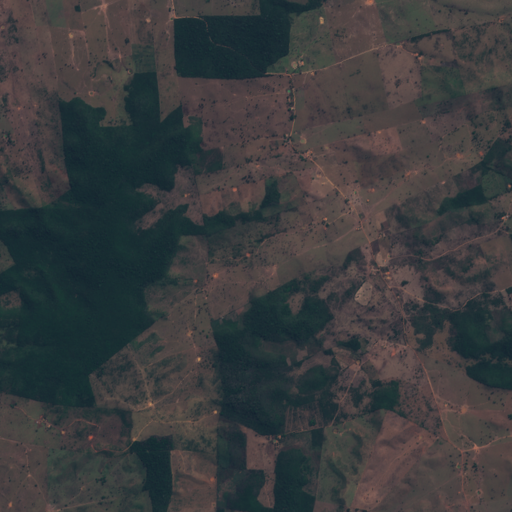

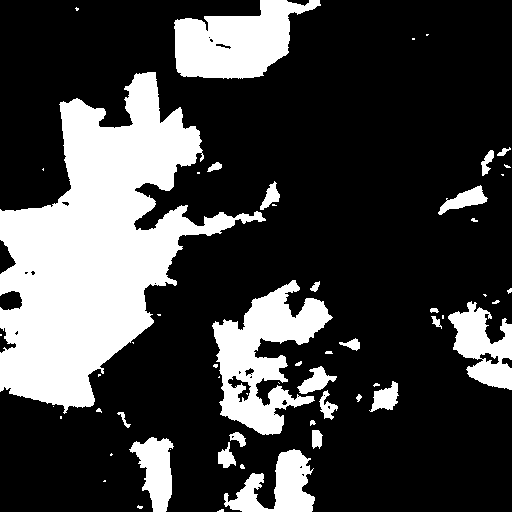

In [70]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import random as rnd

i = rnd.randrange(0, len(input_img_paths) - 1)

# Displays random input image
display(Image(filename=input_img_paths[i]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img)

In [71]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            data = np.array(img)[:, :, 0]
            data = np.expand_dims(data, 2)
            y[j] = data
            y[j] = np.divide(y[j], 255)
        return x, y

In [72]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [73]:
import random

# Split our img paths into a training and a validation set using 80/20 split
val_samples = int(len(input_img_paths) * 0.2)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [74]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 25
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
22/22 [==============================] - 9s 208ms/step - loss: 4.4617 - val_loss: 3.2316
Epoch 2/25
22/22 [==============================] - 4s 182ms/step - loss: 0.6054 - val_loss: 10.1246
Epoch 3/25
22/22 [==============================] - 4s 185ms/step - loss: 0.6188 - val_loss: 6.4508
Epoch 4/25
22/22 [==============================] - 4s 183ms/step - loss: 0.4865 - val_loss: 3.4752
Epoch 5/25
22/22 [==============================] - 4s 184ms/step - loss: 0.5723 - val_loss: 3.6203
Epoch 6/25
22/22 [==============================] - 4s 185ms/step - loss: 0.3191 - val_loss: 1.3882
Epoch 7/25
22/22 [==============================] - 4s 180ms/step - loss: 0.2419 - val_loss: 2.5524
Epoch 8/25
22/22 [==============================] - 4s 183ms/step - loss: 0.2370 - val_loss: 1.3316
Epoch 9/25
22/22 [==============================] - 4s 183ms/step - loss: 0.2625 - val_loss: 1.4520
Epoch 10/25
22/22 [==============================] - 4s 182ms/step - loss: 0.2240 - val_loss: 0.334

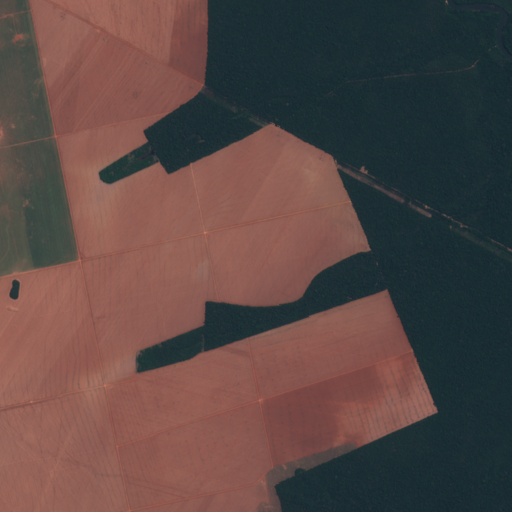

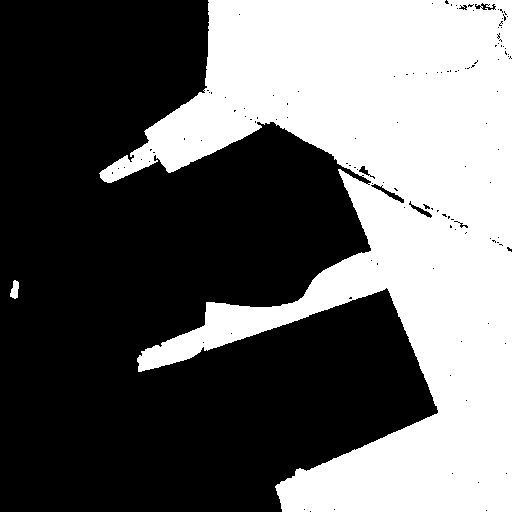

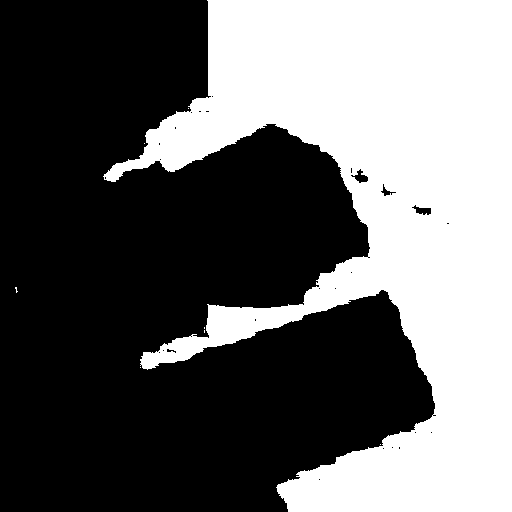

In [75]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #0
i = rnd.randrange(0, len(val_input_img_paths) - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.